TokaMaker Example 4: Simple H-mode scenario in ITER {#doc_tMaker_ex3}
==========
In this example we show how to compute equilibria in ITER with H-mode like profiles for the "inverse" case where we have a desired shape, plasma current and pressure, but the required coil currents are unkown.

This example utilizes the mesh built in \ref doc_gs_mesh_ex2.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python packages. Both of which are installable using `pip` or other standard methods. This example also requires use of the Sauter formula for bootstrap current (See: O. Sauter, et al., Phys. Plasmas 6, 2834 (1999); doi:10.1063/1.873240). It is available as part of the open source platform OMFIT, written as part of the Kolemen Group Automatic Kinetic EFIT Project "auto_kEFIT" (See: https://omfit.io/_modules/omfit_classes/utils_fusion.html).

This formula can be installed using pip:
`$ pip install --upgrade omfit_classes`

The utility function `Hmode_profiles()` is also imported from `omfit_classes` to facilitate specification of a pressure pedestal.

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from omfit_classes.utils_fusion import sauter_bootstrap, Hmode_profiles
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh

## Compute equilibria

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   main
Revision id:          e283e6c
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_gs_mesh_ex2 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('ITER_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict)
mygs.setup(order = 2, F0 = 5.3*6.2)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.859E+02
    # of points  =    4757
    # of edges   =   14156
    # of cells   =    9400
    # of boundary points =     112
    # of boundary edges  =     112
    # of boundary cells  =     112
  Resolution statistics:
    hmin =  9.924E-03
    hrms =  2.827E-01
    hmax =  8.466E-01
  Surface grounded at vertex     870


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.1620000000000001E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibrium we seek to compute below is vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the actual ITER Vertical Stability Coil (VSC).

In [5]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[coil_dict['VSU']['coil_id'], coil_dict['VSL']['coil_id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds". In this case we just the simple and approximate bi-directional limit of 50 MA in each coil.

Note that the size of the bounds array is (ncoils+1,2) as bounds can also be set for the VSC set, which is treated as a separate degree of freedom (virtual coil) if defined.

In [6]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -50.E6; coil_bounds[:,1] = 50.E6
mygs.set_coil_bounds(coil_bounds)

## Compute Inverse Equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [7]:
Ip_target=15.6E6
P0_target=6.2E5
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a handful of isoflux points that we want to lie on the LCFS of the target equilibrium. Additionally, we define a single X-point and set it as a saddle constraint as well as adding it to the list of isoflux points.

In [8]:
isoflux_pts = np.array([
    [ 8.20,  0.41],
    [ 8.06,  1.46],
    [ 7.51,  2.62],
    [ 6.14,  3.78],
    [ 4.51,  3.02],
    [ 4.26,  1.33],
    [ 4.28,  0.08],
    [ 4.49, -1.34],
    [ 7.28, -1.89],
    [ 8.00, -0.68]
])
x_point = np.array([[5.125, -3.4],])
mygs.set_isoflux(np.vstack((isoflux_pts,x_point)))
mygs.set_saddles(x_point)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we use the identity as the regularization matrix, with zero for all targets and modest weights on the CS and PF coils. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Note that the VSC set has a large weight as we also use the regularization matrix to prevent up-down symmetric current in these coils. The actual up-down asymmetric current will be provided by the dedicated VSC virtual coil.

In [9]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))

# Set regularization weights
for key, coil in coil_dict.items():
    if key.startswith('CS'):
        if key.startswith('CS1'):
            coil_reg_weights[coil['coil_id']] = 2.E-2
        else:
            coil_reg_weights[coil['coil_id']] = 1.E-2
    elif key.startswith('PF'):
        coil_reg_weights[coil['coil_id']] = 1.E-2
    elif key.startswith('VS'):
        coil_reg_weights[coil['coil_id']] = 1.E2 # Force "regular" current to zero in VSC
# Set weight for VSC virtual coil
coil_reg_weights[-1] = 1.E-2

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an H-mode-like kinetic profiles parametrized via the OMFIT function `Hmode_profiles()` (see note at top). Within TokaMaker these profiles are represented as piecewise linear functions, which can be set up using the dictionary approach shown below.

Using the OMFIT `Hmode_profiles()` profile parametrization function, we can specify ITER-like H-mode profiles. See Figs. 18 and 19 for these $n_e$ and $T_e$ profiles: https://iopscience.iop.org/article/10.1088/0029-5515/48/7/075005/pdf

Additionally, we specify an L-mode toroidal current profile, to which we will add a non-inductive component generated by the boostrap current and calculated by the Sauter formula.

For pressure, we are assuming a quasineutral and isothermal plasma, (i.e. ne = ni, Te = Ti), however this assumption is not usually valid in the core and separate ion profiles will need to be specified. 

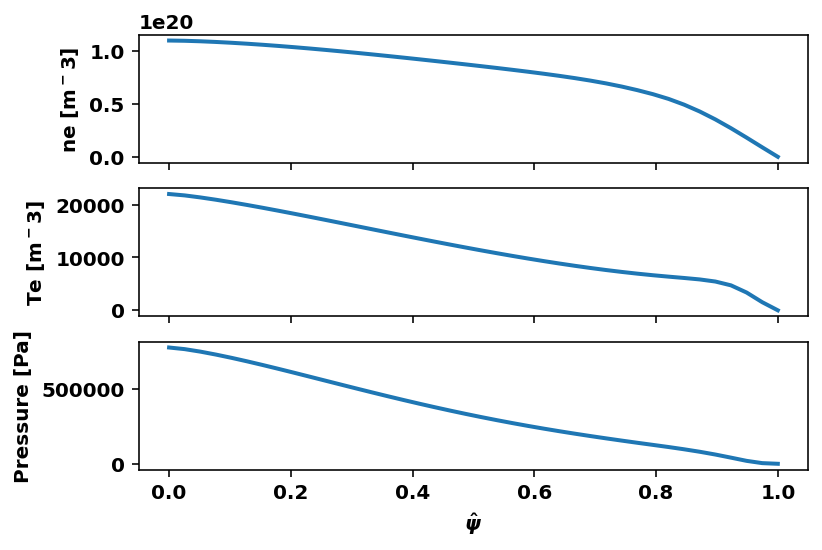

In [10]:
n_sample = 40
psi_sample = np.linspace(0.0,1.0,n_sample)

### Define ne and Te profiles
xphalf = 0.965
widthp_Te = 0.1
widthp_ne = 0.35

ne = Hmode_profiles(edge=0., ped=0.6, core=1.1, rgrid=n_sample, expin=1.6, expout=1.6, widthp=widthp_ne, xphalf=xphalf) * 1e20
Te = Hmode_profiles(edge=0., ped=5000., core=22000., rgrid=n_sample, expin=1.3, expout=1.7, widthp=widthp_Te, xphalf=xphalf)
ni = ne.copy() # Assuming quasineutrality
Ti = Te.copy() # Assuming isothermal
pressure = (1.602e-19 * ne * Te) + (1.602e-19 * ni * Ti) # 1.602e-19 * [m^-3] * [eV] = [Pa]

### Set up possible L-mode, inductive Jtor
jtor_noBS = Hmode_profiles(edge=0.0, ped=0.01, core=1.7, rgrid=n_sample, expin=1.0, expout=1.4, widthp=0.001, xphalf=None) * 1e+6

fig, ax = plt.subplots(3,1,sharex=True)
# Plot ne
ax[0].plot(psi_sample,ne)
ax[0].set_ylabel("ne [m$^-3$]")
# Plot Te
ax[1].plot(psi_sample,Te)
ax[1].set_ylabel("Te [m$^-3$]")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")
# Plot total pressure
ax[2].plot(psi_sample,pressure)
ax[2].set_ylabel("Pressure [Pa]")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve" is then called to compute a self-consistent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [11]:
R0 = 6.3
Z0 = 0.5
a = 2.0
kappa = 1.4
delta = 0.0
err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)
err_flag = mygs.solve()

Starting non-linear GS solver
     1  1.9347E+00  9.6546E-02  6.1261E-01  6.4473E+00  5.3514E-01  5.0949E+04
     2  4.9716E+00  5.8760E-02  1.5438E-01  6.4130E+00  5.3331E-01  6.7775E+04
     3  5.2558E+00  5.4820E-02  3.6875E-02  6.3964E+00  5.3206E-01  6.9752E+04
     4  5.2899E+00  5.4223E-02  9.1303E-03  6.3898E+00  5.3136E-01  6.9672E+04
     5  5.2902E+00  5.4154E-02  2.5779E-03  6.3874E+00  5.3099E-01  6.9388E+04
     6  5.2880E+00  5.4159E-02  9.1683E-04  6.3866E+00  5.3080E-01  6.9194E+04
     7  5.2867E+00  5.4166E-02  3.8444E-04  6.3864E+00  5.3070E-01  6.9088E+04
     8  5.2862E+00  5.4170E-02  1.6827E-04  6.3863E+00  5.3066E-01  6.9037E+04
     9  5.2860E+00  5.4172E-02  7.3102E-05  6.3862E+00  5.3064E-01  6.9013E+04
    10  5.2860E+00  5.4172E-02  3.1229E-05  6.3862E+00  5.3063E-01  6.9003E+04
    11  5.2859E+00  5.4172E-02  1.3148E-05  6.3862E+00  5.3062E-01  6.8999E+04
    12  5.2859E+00  5.4173E-02  5.4796E-06  6.3862E+00  5.3062E-01  6.8997E+04
    13  5.2859E+00  5.

### Now input kinetic profiles to obtain H-mode solution

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve_with_bootstrap "solve_with_bootstrap" is now called to compute a self-consistent Grad-Shafranov equilibrium that includes non-inductive current (the bootstrap current). Inclusion of bootstrap current effects is essential for H-mode equilibrium stability. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [12]:
Zeff=np.linspace(1.5,1.5,n_sample)
ni = ne.copy()
Ti = Te.copy()

err_flag = mygs.solve_with_bootstrap(psi_sample,n_sample,ne,Te,ni,Ti,jtor_noBS,Zeff,R0)

>>> Initializing equilibrium with pedestal removed:
Starting non-linear GS solver
     1  5.2859E+00  9.7674E-02  3.4824E-01  6.4388E+00  5.2639E-01  1.1311E+05
     2  5.2859E+00  1.3214E-01  6.7996E-02  6.4711E+00  5.2276E-01  1.6209E+05
     3  5.2859E+00  1.1798E-01  4.7502E-02  6.4779E+00  5.2164E-01  1.5302E+05
     4  5.2859E+00  1.2387E-01  1.2912E-02  6.4814E+00  5.2107E-01  1.6217E+05
     5  5.2859E+00  1.2142E-01  7.7280E-03  6.4822E+00  5.2086E-01  1.6014E+05
     6  5.2859E+00  1.2245E-01  2.3293E-03  6.4826E+00  5.2076E-01  1.6168E+05
     7  5.2859E+00  1.2202E-01  1.3118E-03  6.4827E+00  5.2073E-01  1.6128E+05
     8  5.2859E+00  1.2220E-01  4.1340E-04  6.4828E+00  5.2071E-01  1.6154E+05
     9  5.2859E+00  1.2213E-01  2.2616E-04  6.4828E+00  5.2071E-01  1.6147E+05
    10  5.2859E+00  1.2216E-01  7.2940E-05  6.4828E+00  5.2070E-01  1.6151E+05
    11  5.2859E+00  1.2214E-01  3.9261E-05  6.4828E+00  5.2070E-01  1.6150E+05
    12  5.2859E+00  1.2215E-01  1.2832E-05  6.482

Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


Starting non-linear GS solver
     1  5.2859E+00  6.0342E-02  1.8988E-01  6.4742E+00  5.2344E-01  3.7016E+03
     2  5.2859E+00  6.3777E-02  9.6908E-02  6.4714E+00  5.2509E-01 -3.4738E+04
     3  5.2859E+00  6.2632E-02  2.0519E-02  6.4696E+00  5.2576E-01 -4.2513E+04
     4  5.2859E+00  6.3149E-02  1.0397E-02  6.4694E+00  5.2602E-01 -4.4603E+04
     5  5.2859E+00  6.2926E-02  1.3765E-03  6.4692E+00  5.2616E-01 -4.4358E+04
     6  5.2859E+00  6.3010E-02  1.0411E-03  6.4692E+00  5.2621E-01 -4.4292E+04
     7  5.2859E+00  6.2971E-02  2.6968E-04  6.4691E+00  5.2624E-01 -4.4143E+04
     8  5.2859E+00  6.2985E-02  1.3698E-04  6.4691E+00  5.2625E-01 -4.4111E+04
     9  5.2859E+00  6.2978E-02  5.4631E-05  6.4691E+00  5.2625E-01 -4.4084E+04
    10  5.2859E+00  6.2981E-02  2.1268E-05  6.4691E+00  5.2625E-01 -4.4079E+04
    11  5.2859E+00  6.2980E-02  9.0160E-06  6.4691E+00  5.2626E-01 -4.4075E+04
    12  5.2859E+00  6.2980E-02  3.4839E-06  6.4691E+00  5.2626E-01 -4.4074E+04
    13  5.2859E+00  6.

Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


Starting non-linear GS solver
     1  5.2859E+00  6.2980E-02  2.4173E-03  6.4696E+00  5.2620E-01 -4.3266E+04
     2  5.2859E+00  6.3073E-02  3.2468E-04  6.4696E+00  5.2619E-01 -4.3331E+04
     3  5.2859E+00  6.3035E-02  3.5194E-04  6.4696E+00  5.2619E-01 -4.3290E+04
     4  5.2859E+00  6.3052E-02  7.4961E-05  6.4697E+00  5.2619E-01 -4.3315E+04
     5  5.2859E+00  6.3045E-02  5.3325E-05  6.4697E+00  5.2619E-01 -4.3312E+04
     6  5.2859E+00  6.3048E-02  1.5012E-05  6.4697E+00  5.2619E-01 -4.3317E+04
     7  5.2859E+00  6.3047E-02  8.5670E-06  6.4697E+00  5.2619E-01 -4.3316E+04
     8  5.2859E+00  6.3047E-02  2.7365E-06  6.4697E+00  5.2619E-01 -4.3317E+04
     9  5.2859E+00  6.3047E-02  1.4296E-06  6.4697E+00  5.2619E-01 -4.3317E+04
    10  5.2859E+00  6.3047E-02  4.7935E-07  6.4697E+00  5.2619E-01 -4.3317E+04
 Timing:  0.47569799982011318     
   Source:    0.20458300225436687     
   Solve:     0.13658199971541762     
   Boundary:   2.9239998199045658E-002
   Other:     0.105292999651

Got Zeff instead of nis and Zis: density and charge state lists for ion species.
I CAN GIVE YOU AN APPROXIMATION BUT IT'S NOT GOING TO BE AS GOOD AS IF YOU GAVE ME LISTS OF DENSITIES.
You will get a better result if you do not pass in Zeff but use nis and Zis instead.


### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

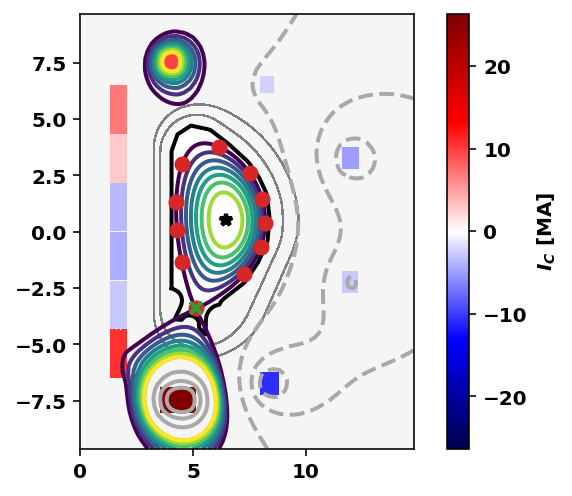

In [13]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')

### Plot final self-consistent P' and FF' including $j_{bootstrap}$ contribution

Text(0.5, 1.0, "H-mode P' and FF'")

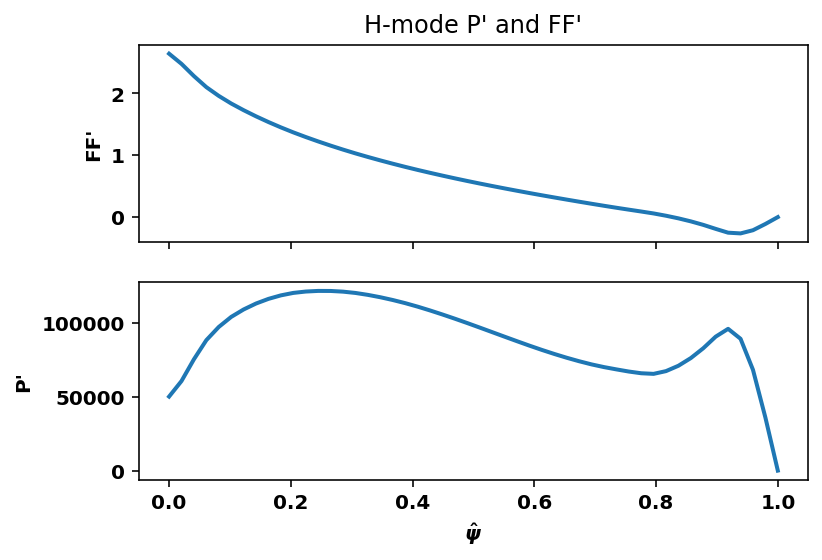

In [14]:
psi,f,fp,p,pp = mygs.get_profiles()

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(psi,f*fp)
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(psi,pp)
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

ax[0].set_title("H-mode P' and FF'")

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents" method, which are all within the approximate coil limits imposed above.

In [15]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in coil_dict:
    i = coil_dict[key]['coil_id']
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[i]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    1.3133E+07
  Current Centroid [m]    =    6.255  0.492
  Magnetic Axis [m]       =    6.470  0.526
  Elongation              =    1.866 (U:  1.718, L:  2.015)
  Triangularity           =    0.459 (U:  0.354, L:  0.563)
  Plasma Volume [m^3]     =   810.179
  q_0, q_95               =    2.137  3.433
  Peak Pressure [Pa]      =    7.7503E+05
  Stored Energy [J]       =    4.0188E+08
  <Beta_pol> [%]          =   94.8826
  <Beta_tor> [%]          =    3.0119
  Diamagnetic flux [Wb]   =    1.1924E-01
  Toroidal flux [Wb]      =    1.1878E+02
  l_i                     =    0.5504

Coil Currents [MA]:
  CS3U:            6.89
  CS2U:            2.74
  CS1U:           -3.66
  CS1L:           -4.24
  CS2L:           -2.85
  CS3L:           10.51
  PF1:             9.84
  PF2:            -2.33
  PF3:            -5.13
  PF4:            -2.84
  PF5:           -10.88
  PF6:            26.32
  VSU:        